In [1]:
!nvidia-smi

Thu Feb 29 00:49:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX330         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   85C    P8             N/A / ERR!  |     108MiB /   2048MiB |     63%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Import data into tensorflow dataset object
dataset=tf.keras.preprocessing.image_dataset_from_directory("C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\Potato Disease Classification\\PlantVillage",
                                                            shuffle=True,
                                                            image_size=(256, 256),
                                                            batch_size=32)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1]


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[144. 134. 143.]
  [145. 135. 144.]
  [144. 134. 143.]
  ...
  [ 97.  89. 102.]
  [ 98.  90. 103.]
  [100.  92. 105.]]

 [[150. 140. 149.]
  [147. 137. 146.]
  [142. 132. 141.]
  ...
  [ 97.  89. 102.]
  [ 98.  90. 103.]
  [100.  92. 105.]]

 [[147. 137. 146.]
  [141. 131. 140.]
  [137. 127. 136.]
  ...
  [ 97.  89. 102.]
  [ 99.  91. 104.]
  [100.  92. 105.]]

 ...

 [[151. 138. 148.]
  [152. 139. 149.]
  [153. 140. 150.]
  ...
  [ 98.  76.  79.]
  [104.  82.  85.]
  [107.  85.  88.]]

 [[152. 139. 149.]
  [152. 139. 149.]
  [152. 139. 149.]
  ...
  [ 97.  75.  78.]
  [101.  79.  82.]
  [102.  80.  83.]]

 [[158. 145. 155.]
  [155. 142. 152.]
  [153. 140. 150.]
  ...
  [106.  84.  87.]
  [107.  85.  88.]
  [ 89.  67.  70.]]], shape=(256, 256, 3), dtype=float32)


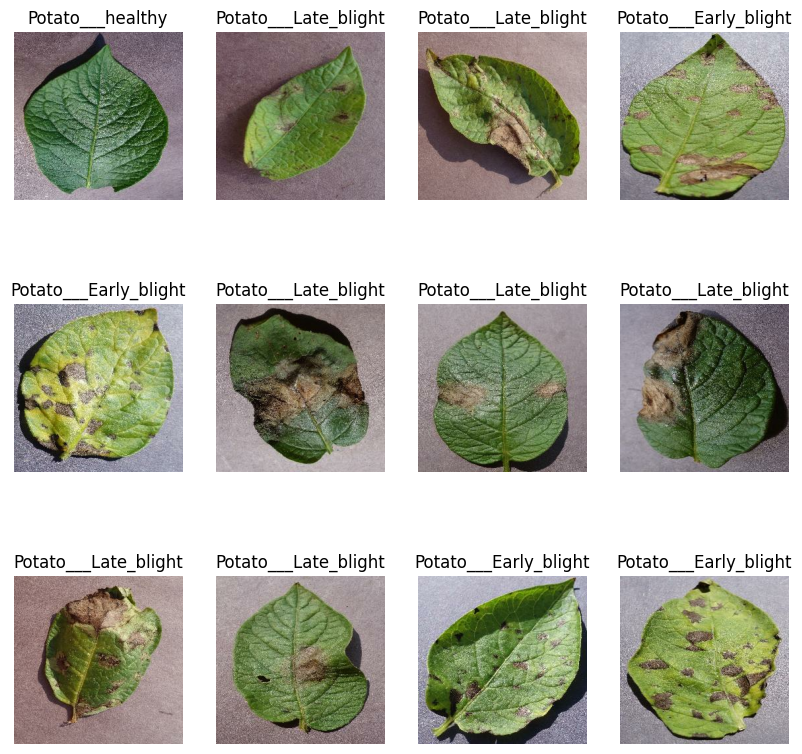

In [8]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels_batch[i]])

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [9]:
#80%->training
#20%->10% validation,10%test

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)


54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
#Building Model
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256), 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [27]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 345s 6s/step - loss: 0.9168 - accuracy: 0.4838 - val_loss: 0.8471 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 96s 2s/step - loss: 0.7610 - accuracy: 0.6227 - val_loss: 0.5575 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 53s 972ms/step - loss: 0.5204 - accuracy: 0.7627 - val_loss: 0.5060 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 53s 977ms/step - loss: 0.3987 - accuracy: 0.8339 - val_loss: 0.2871 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 47s 878ms/step - loss: 0.2281 - accuracy: 0.9109 - val_loss: 0.2624 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 48s 881ms/step - loss: 0.1726 - accuracy: 0.9294 - val_loss: 0.0996 - val_accuracy: 0.9740
Epoch 7/50
54/54 [==============================] - 48s 888ms/step - loss: 0.1442 - accuracy: 0.9456 - val_loss: 0.0783 - val_accuracy: 0.9740
Ep

In [28]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 107s 733ms/step - loss: 1.1602e-04 - accuracy: 1.0000


In [29]:
scores

[0.00011602247104747221, 1.0]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.48379629850387573,
 0.6226851940155029,
 0.7627314925193787,
 0.8339120149612427,
 0.9108796119689941,
 0.9293981194496155,
 0.9456018805503845,
 0.9363425970077515,
 0.9600694179534912,
 0.9739583134651184,
 0.9832175970077515,
 0.9797453880310059,
 0.9849537014961243,
 0.9837962985038757,
 0.9907407164573669,
 0.9930555820465088,
 0.9913194179534912,
 0.9519675970077515,
 0.9890046119689941,
 0.9577546119689941,
 0.984375,
 0.9976851940155029,
 0.9994212985038757,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [34]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

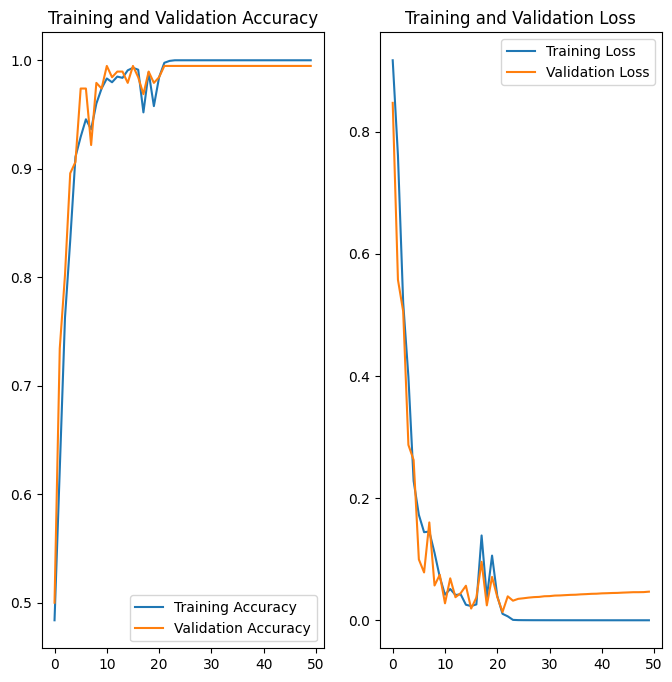

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 6s 6s/step
predicted label: Potato___Early_blight


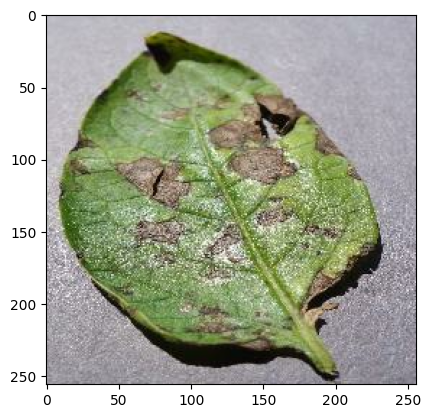

In [36]:
#Run prediction on a sample image
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 33ms/step


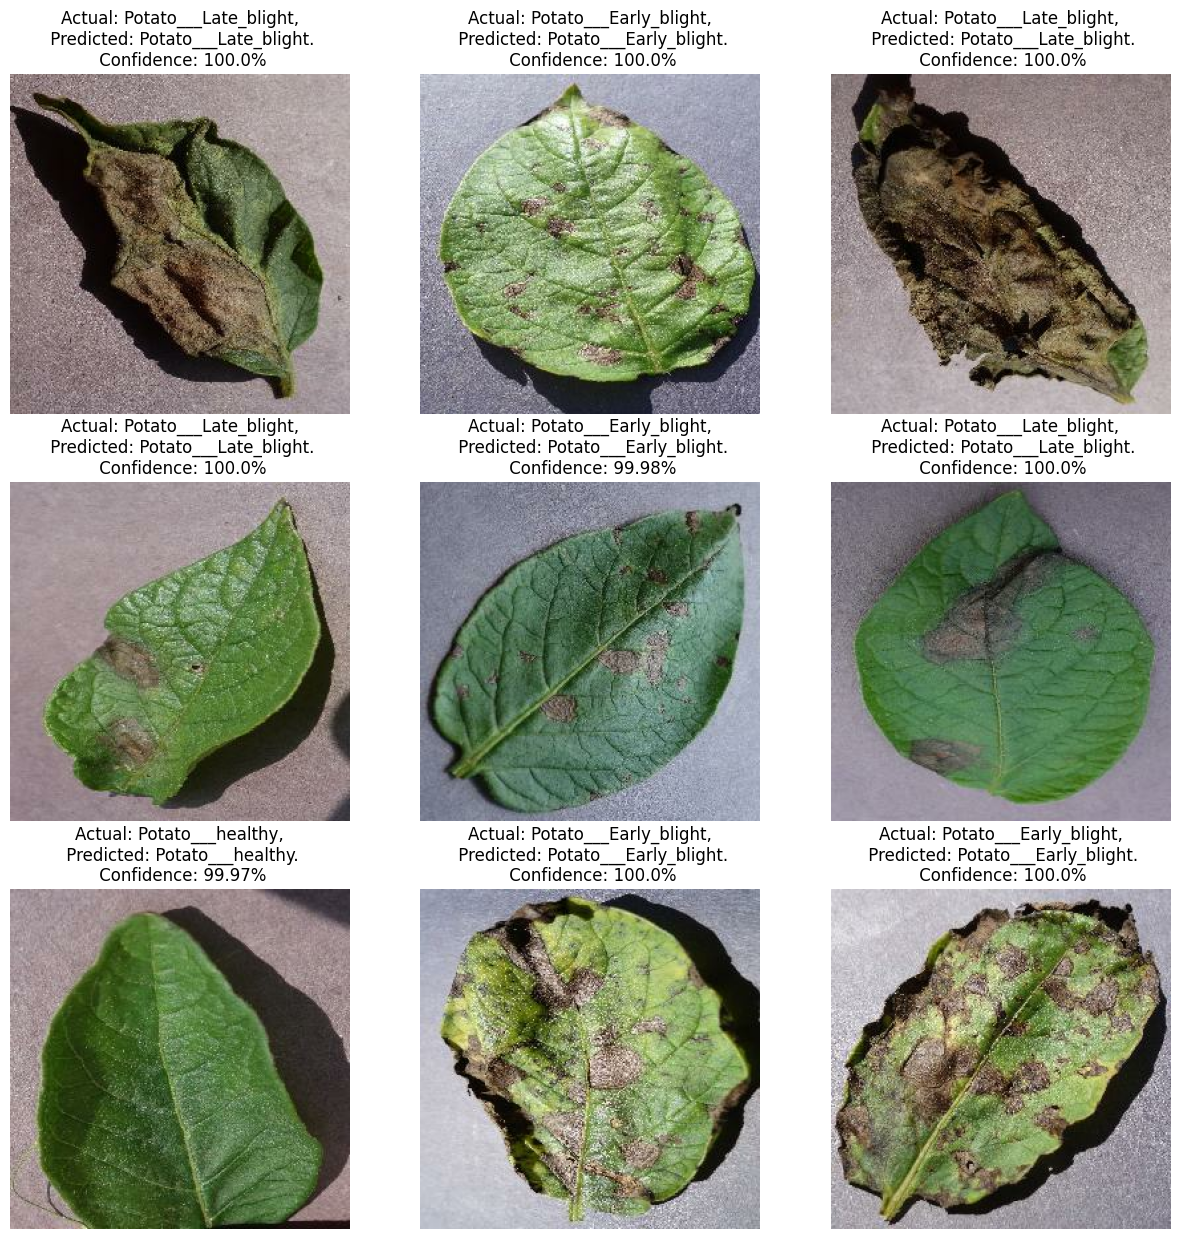

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
#saving the model
import os 
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [42]:
model.save("./potatoes.h5")